In [3]:
'''
传统神经网络用的是Full connection全连接输入一般为： batch_size * 784，然后走全连接去训练模型和预测
   CNN卷积神经网络是适用图像 batch_size*1(channel)*28(height)*28(weight)，走卷积（conv)去训练模型和预测

回归任务：  1。 输入是一些数据 
           2。经过n层nn网络
           3。得出一个预测结果 
1，2，3步统称为回归任务
'''


'\n回归任务：  1。 输入是一些数据 \n           2。经过n层nn网络\n           3。得出一个预测结果 \n1，2，3步统称为回归任务\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\patrick\anaconda3\envs\transformer-3\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
features = pd.read_csv('data/temps.csv')
features.head()
print('数据维度:', features.shape)

数据维度: (348, 9)


In [3]:
years = features['year']
months = features['month']
days = features['day']
#datetime format
dates = [str(int(year)) + '-' + str(int(month)) +'-'+str(int(day)) for year, month, day in zip(years,months,days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

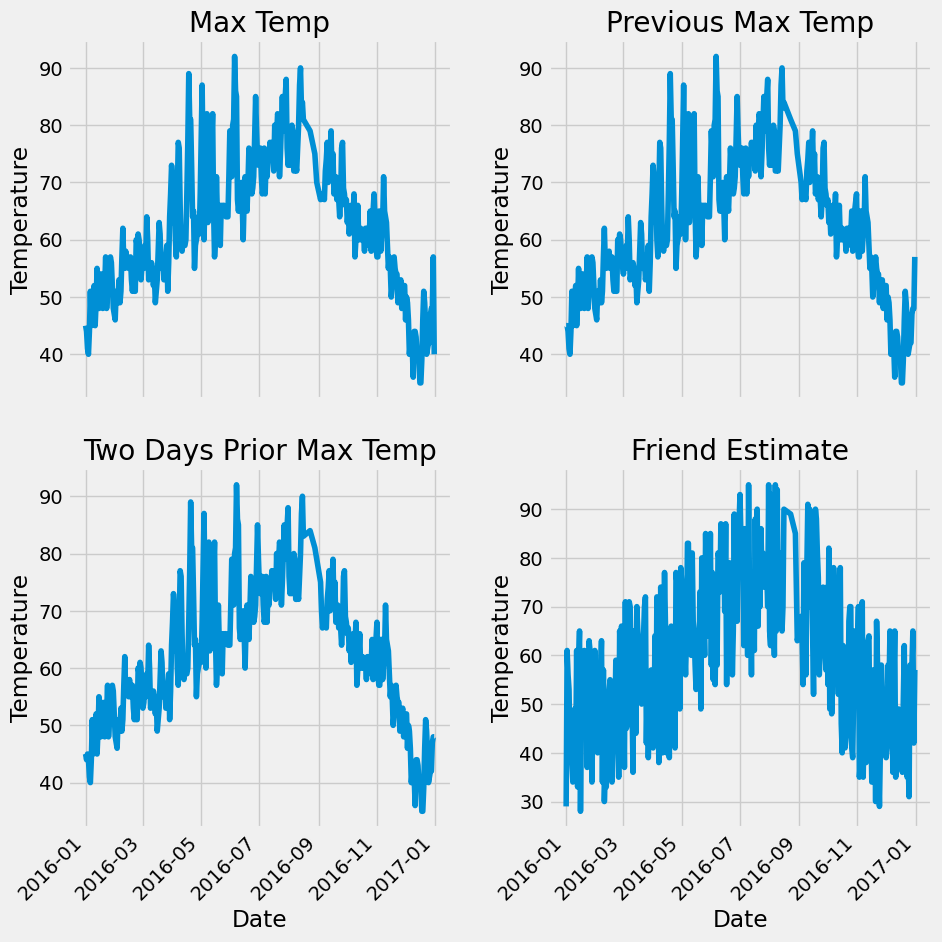

In [4]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 我的逗逼朋友
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [5]:
#独热编码 将星期数据（Fri/Sat/Mon)转换成true false编码
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


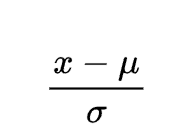

x-mean/std  -> 标准化数据 

In [6]:
# 标签, y值 ，需要预测出来的，所以需要先删除
labels = np.array(features['actual'])
# 在特征中去掉标签
features_1 = features.drop('actual', axis = 1)

# 名字单独保存一下，以备后患
feature_list = list(features_1.columns)

# 转换成合适的格式
features_1 = np.array(features_1)


'''
标准化处理x-mean/std  -> 标准化数据 
'''
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features_1)

In [8]:
input_features

array([[ 0.        , -1.5678393 , -1.65682171, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.54267126, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        , -1.5678393 , -1.4285208 , ..., -0.40482045,
        -0.41913682, -0.40482045],
       ...,
       [ 0.        ,  1.5810006 ,  1.53939107, ...,  2.47023092,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.65354153, ..., -0.40482045,
        -0.41913682, -0.40482045],
       [ 0.        ,  1.5810006 ,  1.76769198, ..., -0.40482045,
        -0.41913682, -0.40482045]])

In [7]:
'''
Option1
#构造复杂的网络模型
#一步一步手动调用，少用第三方库的方法
'''

x = torch.tensor(input_features, dtype=float)
y = torch.tensor(labels, dtype=float)

#s1: 权重参数初始化
weights = torch.randn((14,128), dtype=float, requires_grad=True) ##输入是14，是什么？是原数据中的特征，也就是列数；输出是128，为给定的隐层的神经元个数
biases = torch.randn(128, dtype = float, requires_grad=True)
weights2 = torch.randn((128,1), dtype=float, requires_grad=True)##输入是128；输出是1，即预测的温度值 
biases2 = torch.randn(1, dtype=float, requires_grad=True)

learning_rate = 0.001
losses = []
#更新1000次，类似epoch概念？
for i in range(1000):
    #s2: 计算隐层
    '''x.mm - mat multiply矩阵乘法，计算x*W + b
    x (1,14) * weight(14,128) + b(128,1)
    '''
    hidden = x.mm(weights) + biases
    #s3:加入激活函数-损失函数，计算损失
    hidden = torch.relu(hidden)
    #s4:预测结果 
    predictions = hidden.mm(weights2) + biases2
    print('prediction:', predictions[0])
    #s5:计算损失
    loss = torch.mean((predictions - y)**2)
    losses.append(loss.data.numpy()) ##仅用于后面画图
    #打印损失值
    if i % 100 == 0:
        print('loss:', loss)
    #s5:反向传播？为什么需要？不是说pytorch框架不需要反向传播吗？ - 如果继承torch Module并实现forward方法，是不用调用backwrad()的
    loss.backward()

    #s6:手动更新参数，如果用torch forward方法是不用的
    #可以直接使用第三方库，不用这么麻烦，下面代码仅用于示例
    weights.data.add_(- learning_rate * weights.grad.data) # - learning_rate 负号代表梯度的反方向
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)

    #s7:每次迭代都记得清空 - torch的特点之一
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()
    

prediction: tensor([-108.1293], dtype=torch.float64, grad_fn=<SelectBackward0>)
loss: tensor(9466.6566, dtype=torch.float64, grad_fn=<MeanBackward0>)
prediction: tensor([23.7917], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([48.6214], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([57.7342], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([62.4790], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([65.3755], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([67.2599], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([68.5321], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([69.4339], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([70.0637], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([70.4907], dtype=torch.float64, grad_fn=<SelectBackward0>)
prediction: tensor([70.7776], dtype=torch.float64, grad_fn=<SelectBack

In [10]:
predictions.shape

torch.Size([348, 1])

In [11]:
'''
Option2
#构造简单的网络模型
'''

'''1. 进行模型训练'''
input_size = input_features.shape[1] #input_size=输入特征个数 ， shape[0]=行数，样本数 shape[1]=列数=14=是特征数
hidden_size = 128
hidden2_size = 256
output_size=1
batch_size=16
#Sequential - 按输入参数的顺序执行
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size), #自动初始化weight，实现Wx+b的全连接 ，替代上面s1 - s4的步骤
    torch.nn.ReLU(), ##Sigmoid或者nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden2_size), 
    torch.nn.ReLU(), ##Sigmoid或者nn.ReLU(),
    torch.nn.Linear(hidden2_size, output_size)
)
cost = torch.nn.MSELoss(reduction='mean') ##替代上面s5的步骤
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001) ##实现更新参数操作，替代上面s6步骤
#train NN
losses = []
for i in range(10000):
    batch_loss = []
    #use MINI-Batch to train
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype = torch.float, requires_grad=True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()#替代上面s7步骤
        loss.backward(retain_graph=True)
        optimizer.step()##更新参数，替代上面s6步骤
        batch_loss.append(loss.data.numpy())
    if i % 100 ==0 :
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))
        


0 3800.0874
100 61.962803
200 37.036354
300 40.52374
400 44.186554
500 45.436073
600 42.02489
700 37.598125
800 37.823803
900 36.83608
1000 37.705807
1100 36.841442
1200 34.875732
1300 37.930737
1400 35.88287
1500 35.56676
1600 36.228165
1700 35.870235
1800 34.78329
1900 32.872574
2000 35.60709
2100 32.718094
2200 34.323784
2300 32.382816
2400 34.49385
2500 32.007137
2600 33.578495
2700 33.04394
2800 31.932484
2900 33.613125
3000 31.471758
3100 32.92039
3200 31.732855
3300 32.288235
3400 31.424072
3500 32.748238
3600 31.81849
3700 30.961342
3800 32.050133
3900 31.575254
4000 31.23181
4100 32.30419
4200 31.706213
4300 31.669477
4400 31.84259
4500 30.691893
4600 31.906353
4700 31.010546
4800 31.70861
4900 30.875494
5000 31.11804
5100 31.480968
5200 31.404457
5300 31.475697
5400 31.308672
5500 31.56958
5600 31.192461
5700 30.561037
5800 31.204754
5900 30.822071
6000 31.335838
6100 30.706196
6200 30.37498
6300 30.492815
6400 30.42559
6500 30.58563
6600 31.032885
6700 30.644148
6800 30.7618

In [12]:
'''2. 用训练好的模型进行预测'''

x = torch.tensor(input_features, dtype=torch.float)
predict = my_nn(x).data.numpy() ##得出预测结果 


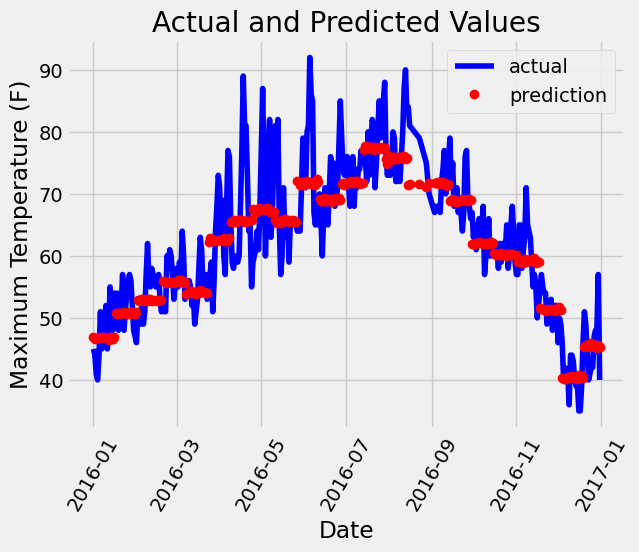

In [13]:
'''画图'''
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features_1[:, feature_list.index('month')]
days = features_1[:, feature_list.index('day')]
years = features_1[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)}) 

# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60); 
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');